In [3]:
#Importing packages
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import keras.models

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import  RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [5]:
#Loading the data
path = '1661-0.txt'
text = open(path,encoding = "utf8").read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [6]:
#Data Preprocessing
character = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(character))
indices_char = dict((i, c) for i, c in enumerate(character))
 
print(f'unique chars: {len(character)}')

unique chars: 73


In [7]:
#chunk 40 characters with 3 sequences
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len ])
    next_chars.append(text[i + seq_len])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


In [8]:
# generating our features and labels
#one hot encoding
X = np.zeros((len(sentences), seq_len, len(character)), dtype=bool)
y = np.zeros((len(sentences), len(character)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

sentences[124]
next_chars[100]

'e'

In [28]:
#one hot encoded data
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [29]:
#one hot encoded data
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [30]:
X.shape

(193950, 40, 73)

In [31]:
y.shape

(193950, 73)

In [32]:
# Creating the model
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               103424    
                                                                 
 dense_7 (Dense)             (None, 73)                9417      
                                                                 
 activation_1 (Activation)   (None, 73)                0         
                                                                 
Total params: 112841 (440.79 KB)
Trainable params: 112841 (440.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
# Training our model
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y,
                    validation_split=0.01, 
                    batch_size=128,
                    epochs=30, 
                    shuffle=True).history

Epoch 1/30
1501/1501 [==============================] - 109s 70ms/step - loss: 2.0399 - accuracy: 0.4024 - val_loss: 2.2584 - val_accuracy: 0.3716
Epoch 2/30
1501/1501 [==============================] - 121s 80ms/step - loss: 1.6691 - accuracy: 0.4994 - val_loss: 2.0905 - val_accuracy: 0.4175
Epoch 3/30
1501/1501 [==============================] - 103s 69ms/step - loss: 1.5468 - accuracy: 0.5325 - val_loss: 2.0341 - val_accuracy: 0.4273
Epoch 4/30
1501/1501 [==============================] - 104s 69ms/step - loss: 1.4827 - accuracy: 0.5517 - val_loss: 1.9255 - val_accuracy: 0.4562
Epoch 5/30
1501/1501 [==============================] - 106s 71ms/step - loss: 1.4411 - accuracy: 0.5616 - val_loss: 1.8900 - val_accuracy: 0.4799
Epoch 6/30
1501/1501 [==============================] - 100s 67ms/step - loss: 1.4104 - accuracy: 0.5704 - val_loss: 1.9379 - val_accuracy: 0.4737
Epoch 7/30
1501/1501 [==============================] - 101s 67ms/step - loss: 1.3883 - accuracy: 0.5756 - val_loss: 1

In [35]:
#saving our model
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

c:\Users\Ajay Kumar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
#loading our model
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

In [37]:
#Model Evaluation
loss_and_acc=model.evaluate(X,y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

6061/6061 [==============================] - 72s 12ms/step - loss: 1.2115 - accuracy: 0.6221
Test Loss 1.211517333984375
Test Accuracy 0.6220881938934326


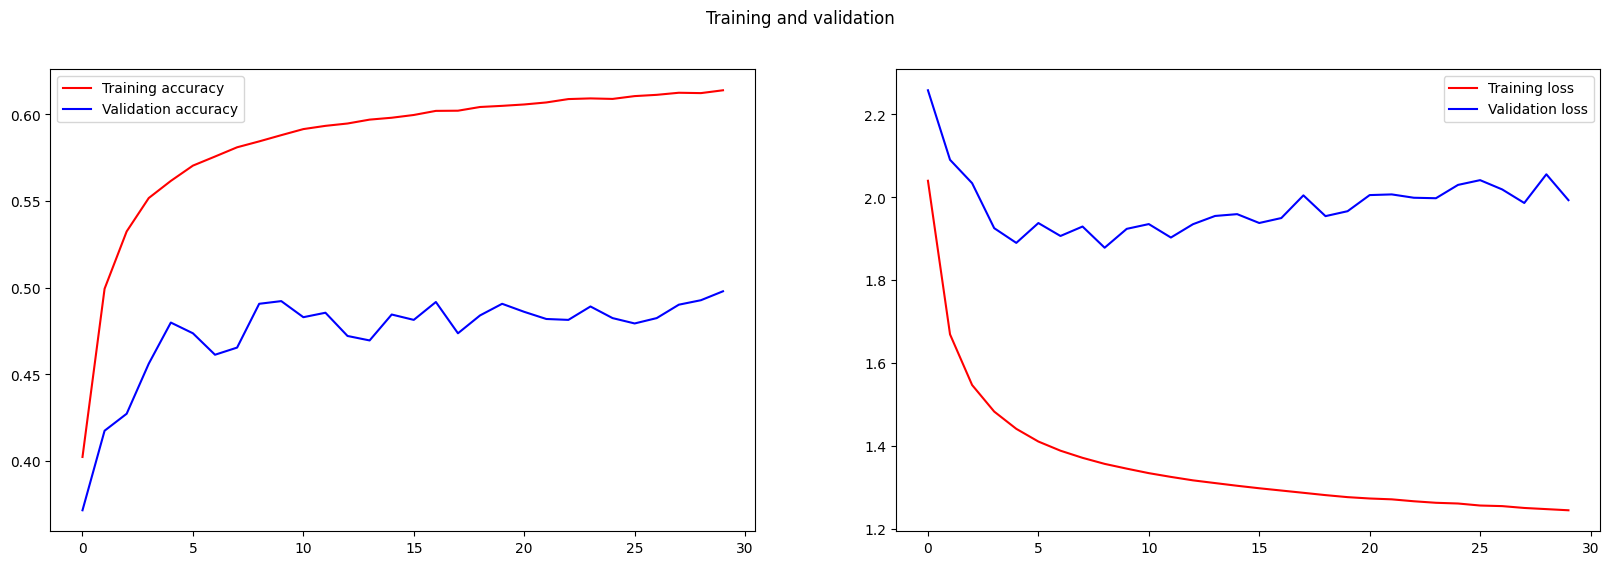

In [38]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))



fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'r', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

In [39]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

prepare_input("This is an example of input of our model".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [40]:
#functions to get next probable characters
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [41]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [42]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [43]:
#Prediction
quotes = [   
    "Deep learning is subset of machine learning,which is essentially a neural network with three or more layers.",
    "Machine learning  is the study of computer algorithms that improve automatically through experience and by the use of data.",
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "Recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data.",
    "Thanks for spending your precious time to view my work."  
    
]

In [44]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

deep learning is subset of machine learn
['er ', ' to ', 'ing ', 'ot ', ', ']

machine learning  is the study of comput
['ion ', 'eless ', ' of ', 'aire ', '\nthe ']

it is not a lack of love, but a lack of 
['the ', 'montyd ', 'a ', 'her ', 'some ']

recurrent neural network (rnn) is a type
['wrealy ', 'r ', 'or. ', 'ar ', 'perty ']

thanks for spending your precious time t
['hat ', 'o ', 'rade ', 'ell ', 'ake ']

